<a href="https://colab.research.google.com/github/shanekim/Portfolio/blob/master/LSTM-XBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM on XBTUSD

In [0]:
# !pip3 install bitmex

In [5]:
import pandas as pd
import math
import os.path
import time
from bitmex import bitmex
# from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook 

### API
bitmex_api_key = 'HBrbYUXDFAlSHtvyJ4JiJ9dd'   
bitmex_api_secret = '-cQeHYcTpYnrLFagZnQdy_HjdksM_d7fazi23wgfho0x7vUh'
binance_api_key = '[REDACTED]'   
binance_api_secret = '[REDACTED]' 

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)

### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


/usr/local/lib/python3.6/dist-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [6]:
data = get_all_bitmex("XBTUSD", "1h", save=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



All caught up..!


In [7]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Loading csv

In [15]:
import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, merge, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/content/drive/My Drive/Data to model/XBTUSD-1h-data.csv")
df['timestamp']= pd.to_datetime(df['timestamp']) 
df = df.set_index('timestamp')

df = df.iloc[:,[1,2,3,4,6,7]]

df.dropna(inplace=True)

df.head(10)

1.15.0


,open,high,low,close,volume,vwap
timestamp,,,,,,
2015-09-25 13:00:00+00:00,239.99,239.99,237.36,237.45,11501,237.418
2015-09-25 14:00:00+00:00,237.45,237.05,236.08,236.08,22625,236.242
2015-09-25 15:00:00+00:00,236.08,236.52,236.10,236.34,17434,236.265
2015-09-25 16:00:00+00:00,236.34,236.13,235.44,235.71,26900,235.732
2015-09-25 17:00:00+00:00,235.71,236.01,235.46,235.75,29200,235.793
2015-09-25 18:00:00+00:00,235.75,236.21,235.60,235.60,20335,235.925
2015-09-25 19:00:00+00:00,235.60,236.15,235.85,236.10,25691,236.054
2015-09-25 20:00:00+00:00,236.10,236.12,235.44,235.44,4500,235.853
2015-09-25 21:00:00+00:00,235.44,235.66,235.03,235.03,11240,235.276


In [16]:
df['hour'] = df.index.hour
df['day']  = df.index.weekday
df['week'] = df.index.week
df['month'] = df.index.month

df['volume'] = pd.to_numeric(df['volume'])
df['close']  = pd.to_numeric(df['close'])
df['open']   = pd.to_numeric(df['open'])
df['high']   = pd.to_numeric(df['high'])
df['low']   = pd.to_numeric(df['low'])
df['vwap']   = pd.to_numeric(df['vwap'])

df['buy_vol'] = df['volume'] * (df['close'] - df['low'])/(df['high'] - df['low'])
df['sell_vol'] = df['volume'] * (df['high'] - df['close'])/(df['high'] - df['low'])
df['momentum']   = df['volume'] * (df['open'] - df['close'])
df['avg_price']  = (df['low'] + df['high'])/2
df['range']      = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
df['oc_diff']      = df['open'] - df['close']


inputs = {
    'open'   : df['open'].values,
    'high'   : df['high'].values,
    'low'    : df['low'].values,
    'close'  : df['close'].values,
    'volume' : df['volume'].values
}

df["MA21"] = df["close"].rolling(window=21).mean()
df.dropna(inplace=True)

df['bear_power'] = df['low'] - df['close']
df['bull_power'] = df['high'] - df['close']

pca_input = df.copy()
pca_features = pca_input.columns.tolist()
pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(pca_input.values.astype('float32'))

# df["y"] = df[["close"]].shift(-3)


df.head(10)

,open,high,low,close,volume,vwap,hour,day,week,month,buy_vol,sell_vol,momentum,avg_price,range,ohlc_price,oc_diff,MA21,bear_power,bull_power,pca
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-09-26 12:00:00+00:00,233.35,233.85,232.91,233.85,23572,233.157,12,5,39,9,23572.000000,0.000000,-11786.00,233.380,0.94,233.4900,-0.50,234.981905,-0.94,0.00,-356566432.0
2015-09-26 13:00:00+00:00,233.85,234.87,234.10,234.68,16625,234.253,13,5,39,9,12522.727273,4102.272727,-13798.75,234.485,0.77,234.3750,-0.83,234.850000,-0.58,0.19,-356438752.0
2015-09-26 14:00:00+00:00,234.68,234.35,234.34,234.34,2050,234.340,14,5,39,9,0.000000,2050.000000,697.00,234.345,0.01,234.4275,0.34,234.767143,0.00,0.01,-356470624.0
2015-09-26 16:00:00+00:00,235.00,235.33,234.85,234.85,550,235.093,16,5,39,9,0.000000,550.000000,82.50,235.090,0.48,235.0075,0.15,234.662381,0.00,0.48,-356456384.0
2015-09-26 17:00:00+00:00,234.85,234.47,233.50,233.74,68830,233.973,17,5,39,9,17030.103093,51799.896907,76401.30,233.985,0.97,234.1400,1.11,234.566667,-0.24,0.73,-356380064.0
2015-09-26 18:00:00+00:00,233.74,233.80,233.68,233.79,5000,233.762,18,5,39,9,4583.333333,416.666667,-250.00,233.740,0.12,233.7525,-0.05,234.480476,-0.11,0.01,-356456864.0
2015-09-26 19:00:00+00:00,233.79,234.00,233.69,234.00,2770,233.905,19,5,39,9,2770.000000,0.000000,-581.70,233.845,0.31,233.8700,-0.21,234.380476,-0.31,0.00,-356457184.0
2015-09-26 20:00:00+00:00,234.00,234.73,234.05,234.35,19538,234.506,20,5,39,9,8619.705882,10918.294118,-6838.30,234.390,0.68,234.2825,-0.35,234.328571,-0.30,0.38,-356463456.0
2015-09-26 21:00:00+00:00,234.35,234.67,234.32,234.63,13932,234.465,21,5,39,9,12339.771429,1592.228571,-3900.96,234.495,0.35,234.4925,-0.28,234.309524,-0.31,0.04,-356460512.0


In [17]:
def create_dataset(dataset, look_back=24):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        # X: Looking back specified period
        a = dataset[i:(i+look_back)]
        dataX.append(a)

        # Y: Predicting the one step after the look-back period
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# x_scaler = MinMaxScaler(feature_range=(0, 1))
# x_scaler = x_scaler.fit(df.drop('close', axis=1).values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(df[['close']].values.astype('float32'))


# Create dataset
  # y: index position of 'high' column
target_index = scaled.columns.tolist().index('close')
dataset = scaled.values.astype('float32')

X, y = create_dataset(dataset)
y = y[:,target_index]

train_size = int(len(X) * 0.9)

trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(34922, 24, 21) (34922,) (3881, 24, 21) (3881,)


In [0]:
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='relu'))

In [21]:
from keras.callbacks import ModelCheckpoint
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(trainX, trainY, epochs=50, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Train on 31429 samples, validate on 3493 samples
Epoch 1/50
31429/31429 [==============================] - 11s 353us/step - loss: 0.0015 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_mean_squared_error: 0.0016

Epoch 00001: val_mean_squared_error improved from inf to 0.00163, saving model to weights.best.hdf5
Epoch 2/50
31429/31429 [==============================] - 8s 247us/step - loss: 4.9353e-04 - mean_absolute_error: 0.0145 - mean_squared_error: 4.9353e-04 - val_loss: 4.7725e-04 - val_mean_absolute_error: 0.0176 - val_mean_squared_error: 4.7725e-04

Epoch 00002: val_mean_squared_error improved from 0.00163 to 0.00048, saving model to weights.best.hdf5
Epoch 3/50
31429/31429 [==============================] - 8s 257us/step - loss: 3.0493e-04 - mean_absolute_error: 0.0115 - mean_squared_error: 3.0493e-04 - val_loss: 4.7843e-04 - val_mean_absolute_error: 0.0175 - val_mean_squared_error: 4.7843e-04

Epoch 00003: va

In [22]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'loss', 'mean_absolute_error', 'mean_squared_error'])


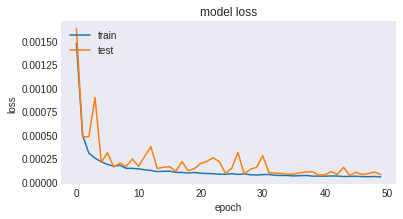

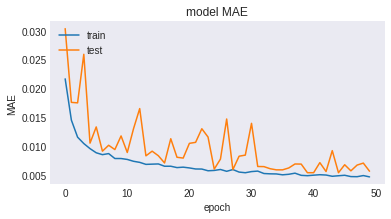

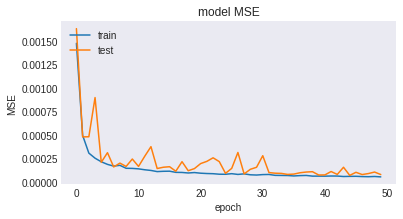

In [23]:
plt.style.use('seaborn-dark')
plt.rcParams["figure.figsize"] = (6,3)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

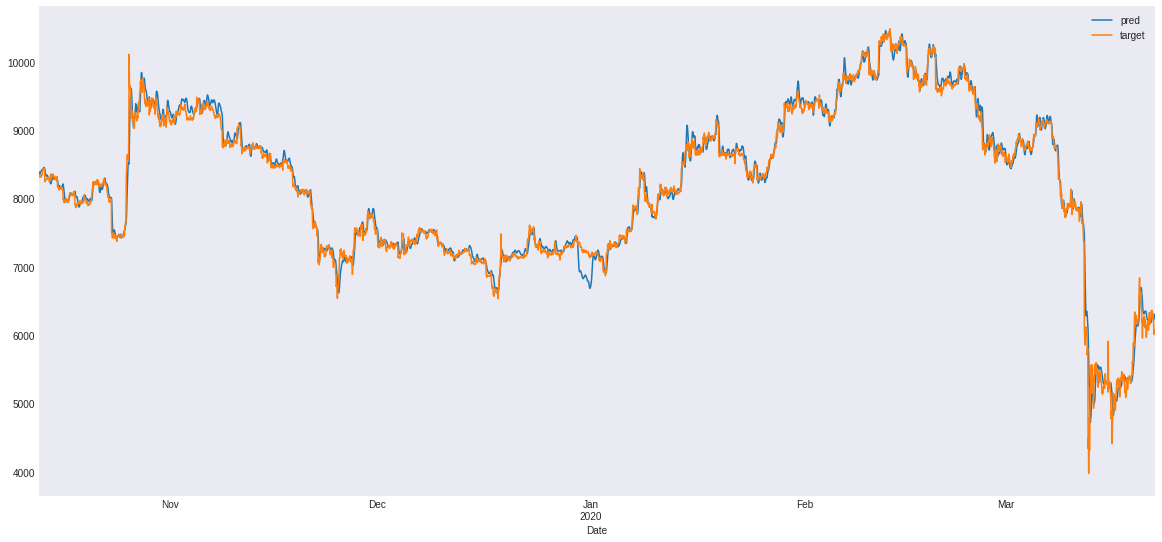

In [24]:
yhat = model.predict(testX)
yhat_inverse = y_scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = y_scaler.inverse_transform(testY.reshape(-1, 1))

pred = pd.DataFrame(yhat_inverse, columns=["pred"])
target = pd.DataFrame(testY_inverse, columns=["target"])

outcome = pd.concat([pred, target], axis=1)
outcome.index = df[-(outcome.shape[0]):].index
outcome.index.names = ['Date']

outcome.plot(figsize=(20,9))

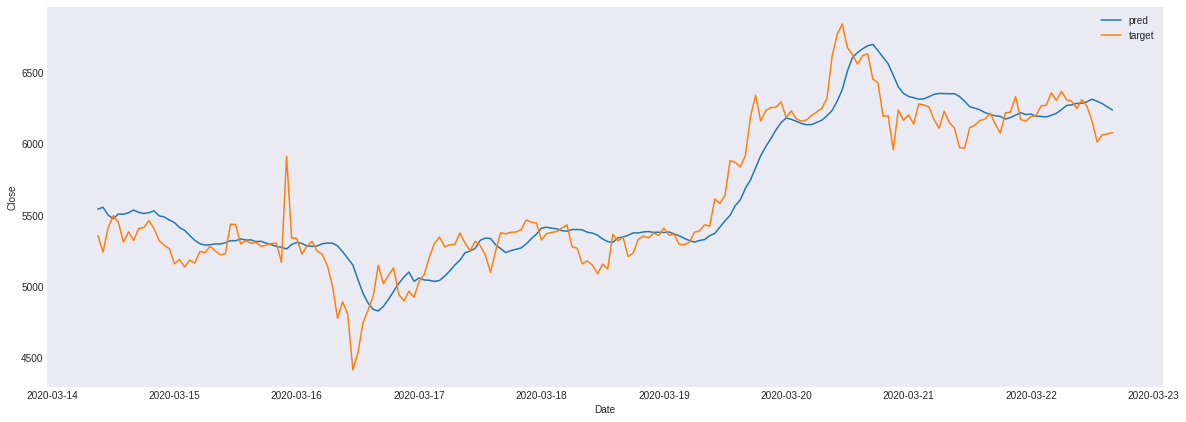

In [26]:
zoom = outcome.iloc[-200:]

threshold = 200

buy = zoom.loc[zoom['pred'] - zoom['target'] > threshold]
sell = zoom.loc[zoom['target'] - zoom['pred'] > threshold]

plt.rcParams["figure.figsize"] = (20,7)

plt.plot(zoom.index, zoom['pred'], label="pred")
plt.plot(zoom.index, zoom['target'], label="target")

# plt.plot(buy.index, zoom.loc[buy.index]['pred'], '^', markersize=5, color='g', label="buy")
# plt.plot(sell.index, zoom.loc[sell.index]['pred'], 'v', markersize=5, color='r', label="sell")

plt.ylabel('Close')
plt.xlabel('Date')
plt.legend()
plt.show()
